In [1]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 4)

import os
import pandas as pd

from DBQuerier import DBQuerier as Querier
from TF_Trainer import TF_Trainer

from crawlab_toolbox import plotting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA

from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras
   
from scipy import signal
from matplotlib.pyplot import colorbar
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
import matplotlib.dates as mdates
import matplotlib as mpl

import seaborn as sns
sns.set(style="ticks")

from crawlab_toolbox import plotting as genplt
import json
import numpy as np
import datetime

tf.random.set_seed(1234)
import matplotlib.colors as colors


In [3]:
DoE = pd.read_csv('EMCO-DOE_v3_Steel.csv')
test_list = [61,62,100]

In [4]:
trainSamples = np.arange(61,81)
trainList = trainSamples.tolist()
trainSamples = np.arange(91,111)
trainList += trainSamples.tolist()
trainSamples = [str(trainList[i]) for i in range(len(trainList))]

In [12]:
# clf_model = create_classifier(param_dict)

querier = Querier('db18','MMM-EMCO-E350',limit=None)

def get_features(startTime,endTime,trainSamples,sampling_interval=None,feature='Vibration',num_classes=2,DoE=None):

    sampleCondition = " and VibrationState.itemInstanceId like 'Sample-%' and VibrationState.motionType = 'Feed'"

    dateTimeCondition = " and VibrationState.dateTime between '" + startTime + "' and '" + endTime + "'"

    featuresDF,_,progName = querier.select_features(
                table=feature,
                labeled=True,
                sampling_interval=sampling_interval,
                extra_condition=sampleCondition + dateTimeCondition,
                itemInstanceIdStr=", VibrationState.itemInstanceId as itemInstanceId ")

    featuresDF = featuresDF.sort_values('dateTime')
    itemInstanceId = list(featuresDF.loc[:, featuresDF.columns == 'itemInstanceId'].values.flatten())

    trainDF_original = featuresDF.loc[featuresDF['itemInstanceId'].isin(trainSamples)]
    testDF_original = featuresDF.loc[featuresDF['itemInstanceId'].isin(trainSamples) == False]
    
    return trainDF_original,testDF_original,featuresDF
    
def create_fft_features(thisDF,DoE):

    Y_list = list(thisDF.loc[:, thisDF.columns == 'itemInstanceId'].values.flatten())
    Y = [DoE.loc[DoE['Sample'] == int(val)]['Tool Type'].values[0] for val in Y_list]

    X = thisDF.loc[:, thisDF.columns != 'itemInstanceId'].values.astype(np.float32)
    DoE = np.array([DoE.loc[DoE['Sample'] == int(val)].values[0][1:-1] for val in Y_list])

    return X,Y,DoE

def fft_from_vib(values):
    freqs,amps = signal.welch(values, fs=20e3, nperseg=4096, scaling='spectrum')
    lin_amps = lin_log_interp(amps)
    return freqs,lin_amps


def lin_log_interp(fft_features):
    '''
    Scale the fft features from the logarithmic axis to be approximately on 
    the interval from 0 to 1
    '''
    
    # Minimum exponent we expect to see in the data
    minimum = -12
    
    # Maximum exponent we expect to see
    maximum = 0
    
    # Number of points to use for interpolation
    numpoints = 1000
    
    # Map the logarithmic x-axis to a linear y-axis
    x = np.logspace(minimum,maximum,numpoints)
    y = np.linspace(0,1,numpoints)

    # Return the interpolated valuess
    return np.interp(np.log10(fft_features),np.log10(x),y)

In [13]:
trainDF_original,testDF_original,fullDF_original = get_features('2020-03-10 00:00:00.000000','2020-03-11 00:00:00.000000',trainSamples,DoE=DoE)

2999-01-01 00:00:00.000000
vibration
SELECT Vibration.sensorId, 
        Vibration.dateTime AS dateTime, 
        Vibration.values AS vals, 
        VibrationState.values as vibState,
        VibrationState.programName as programName, VibrationState.itemInstanceId as itemInstanceId 
        FROM db18.Vibration
        LEFT JOIN db18.VibrationState ON 
        db18.VibrationState.dateTime = db18.Vibration.dateTime 
        where exists 
            (SELECT VibrationState.values from db18.VibrationState WHERE VibrationState.dateTime = Vibration.dateTime)
         
        and Vibration.assetId = 'MMM-EMCO-E350'
           and VibrationState.itemInstanceId like 'Sample-%' and VibrationState.motionType = 'Feed' and VibrationState.dateTime between '2020-03-10 00:00:00.000000' and '2020-03-11 00:00:00.000000'
        order by Vibration.dateTime desc ; 


In [15]:
fullDF_original.shape

(560, 4202)

In [16]:
trainDF_original.shape

(374, 4202)

In [17]:
testDF_original.shape

(186, 4202)

In [19]:
X_train,Y_train,DoE_train = create_fft_features(trainDF_original,DoE)
X_test,Y_test,DoE_test = create_fft_features(testDF_original,DoE)
X_full,Y_full,DoE_full = create_fft_features(fullDF_original,DoE)
num_samples,num_features = X_train.shape
DoE_train /= np.array([[300.,0.003,25]])
# freqs,X_train = fft_from_vib(X_train[:,:-1])
freqs,X_train = signal.welch(X_train[:,:-1], fs=20e3, nperseg=4096, scaling='spectrum')
freqs,X_test = signal.welch(X_test[:,:-1], fs=20e3, nperseg=4096, scaling='spectrum')
freqs,X_full = signal.welch(X_full[:,:-1], fs=20e3, nperseg=4096, scaling='spectrum')

Y_train = tf.keras.utils.to_categorical(Y_train, 2)
samples_train = np.array([trainDF_original['itemInstanceId'].values.astype(int)]).T

In [21]:
columns = ['Date']
# columns += ['FFT-' + str(i) for i in range(bearing1FFT.shape[1])]
times_train = trainDF_original.index.values
ts_train = (times_train - times_train[0]) / np.timedelta64(1, 's') / 60
times_test = testDF_original.index.values
ts_test = (times_test - times_test[0]) / np.timedelta64(1, 's') / 60
times_full = fullDF_original.index.values
ts_full = (times_full - times_full[0]) / np.timedelta64(1, 's') / 60


In [25]:
np.save('data/X_train_Full.npy',X_train)
np.save('data/X_test_Full.npy',X_test)
np.save('data/X_Full.npy',X_full)
np.save('data/time_minutes_train.npy',ts_train)
np.save('data/time_minutes_test.npy',ts_test)
np.save('data/time_minutes_full.npy',ts_full)

In [23]:
def plot_spectrogram(
            time,
            spectrogram,
            frequencyInterval,
            size=(12,4),
            showplot = False,
            save_plot = False,
            transparent = False,
            folder = None,
            filename = 'Spectrogram',
            xlabelpad = 5,    
            ylabelpad = 5,   
            file_type='pdf',
            date_format='%I:00 %p, %b %d',
            xlabel = 'Time'
            ):

    yi = np.arange(-0.0, spectrogram.shape[0] * frequencyInterval,frequencyInterval)
    xi = np.linspace(0.0,1,spectrogram.shape[1]) * np.amax(time)

    X, Y = np.meshgrid(xi, yi)
    plt.figure(figsize=size)
    
    print(X.shape)
    print(Y.shape)
    print(spectrogram.shape)

    # Customize the axes
    ax = plt.gca()
    plt.pcolormesh(X,Y,spectrogram,cmap='cividis',norm=colors.LogNorm(vmin=np.amin(spectrogram),vmax=np.amax(spectrogram)))

    ax.tick_params(labelsize=18)

    cbar = plt.colorbar()
    cbar.set_label(r'\textbf{PSD ($V^2 / Hz$)}', rotation=270,labelpad=20)
    plt.ylabel(r'\textbf{Frequency (Hz)}', labelpad=ylabelpad,fontsize=22)
    plt.xlabel(r'\textbf{' + xlabel + '}', labelpad=xlabelpad,fontsize=22)

    plt.tight_layout(pad=1.2)

    if save_plot:
        if folder is not None:
            # Ensure that the folder we want to save to exists
            if not os.path.exists(folder):
                os.makedirs(folder)

            filename = folder + '/' + filename

        # Save the pdf of the plot    
        if file_type == 'png':
            plt.savefig('{}.png'\
                    .format(filename),transparent=transparent)             
        elif file_type == 'pdf':
            plt.savefig('{}.pdf'\
                    .format(filename))    
        elif file_type == 'svg':
            plt.savefig('{}.svg'\
                    .format(filename)) 

    if showplot:
        plt.show()

    # Clear the axes and figure
    plt.clf()
    plt.cla()
    plt.close()

In [64]:
spectrogram = X_train.astype(float).T
frequencyInterval = freqs[1]

In [65]:
X_train

array([[5.05732487e-06, 1.42297267e-07, 1.95178745e-06, ...,
        5.10879516e-08, 7.48574109e-08, 5.03066069e-08],
       [2.97975987e-07, 8.95482685e-07, 2.85937040e-06, ...,
        4.59050433e-08, 9.12689728e-08, 1.02547496e-07],
       [1.89841126e-06, 8.65133032e-08, 6.60130445e-06, ...,
        2.82628783e-08, 1.01062989e-08, 3.25607874e-10],
       ...,
       [9.20534376e-07, 3.26503937e-07, 1.67138512e-06, ...,
        1.21637385e-07, 8.45867731e-08, 7.25023384e-08],
       [4.54396911e-07, 7.29966416e-07, 7.45520936e-07, ...,
        1.74269346e-08, 1.37556313e-07, 2.00833597e-07],
       [4.11224664e-06, 1.29172463e-06, 1.67650524e-06, ...,
        9.36689926e-09, 1.61439928e-09, 2.48495002e-09]], dtype=float32)

(2048, 374)
(2048, 374)
(2048, 374)


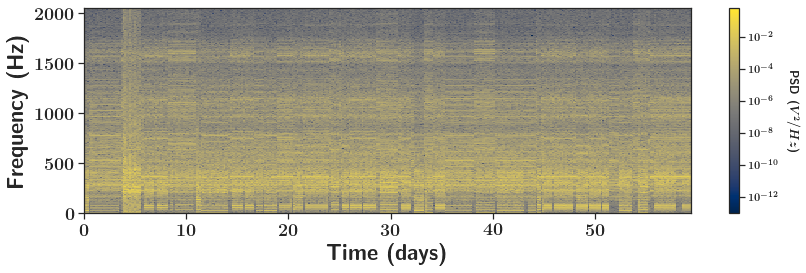

In [66]:
plot_spectrogram(
            ts,
            spectrogram,
            1,
            size=(12,4),
            showplot = True,
            save_plot = False,
            transparent = True,
            folder = 'Figures/IMS2_Spectrogram/',
            filename = 'Bearing1_Spectrogram',
            xlabelpad = 5,    
            ylabelpad = 5,   
            file_type='png',
#             date_format='%I:00 %p, %b %d',
            xlabel='Time (days)'
            )

(2049, 560)
(2049, 560)
(2049, 560)


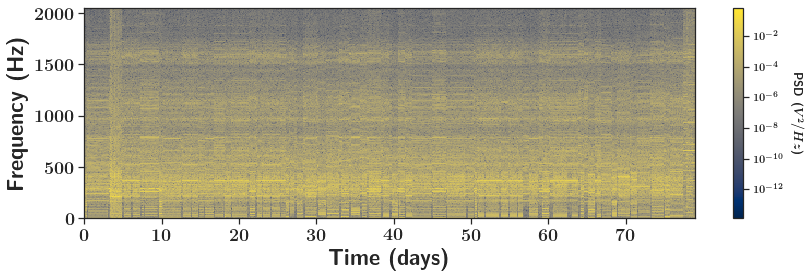

In [24]:
plot_spectrogram(
            ts_full,
            X_full.astype(float).T,
            1,
            size=(12,4),
            showplot = True,
            save_plot = False,
            transparent = True,
            folder = 'Figures/IMS2_Spectrogram/',
            filename = 'Bearing1_Spectrogram',
            xlabelpad = 5,    
            ylabelpad = 5,   
            file_type='png',
#             date_format='%I:00 %p, %b %d',
            xlabel='Time (days)'
            )